In [71]:
import pickle
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from rl.fuzzing_action import FuzzingAction

In [72]:
step = 26000

with open(f"../data/2023-06-13T01:28:.714460/run_data_{step}.pkl", "rb") as f:
    smart_run_data = pickle.load(f)

with open(f"../data/2023-06-11T20:59:.570029_baseline/run_data_{step}.pkl", "rb") as f:
    baseline_run_data = pickle.load(f)

smart_episode_actions = smart_run_data["episode_actions"]
smart_episode_rewards = smart_run_data["episode_rewards"]
smart_losses = smart_run_data["losses"]
smart_execution_coverage = smart_run_data["execution_coverage"]
smart_final_coverage = smart_run_data["current_coverage"]
smart_total_steps = smart_run_data["total_steps"]
smart_total_executions = smart_run_data["total_executions"]

baseline_episode_actions = baseline_run_data["episode_actions"]
baseline_episode_rewards = baseline_run_data["episode_rewards"]
baseline_execution_coverage = baseline_run_data["execution_coverage"]
baseline_final_coverage = baseline_run_data["current_coverage"]
baseline_total_steps = baseline_run_data["total_steps"]
baseline_total_executions = baseline_run_data["total_executions"]

In [73]:
baseline_episode_rewards_summed = [sum(x) for x in baseline_episode_rewards]
smart_episode_rewards_summed = [sum(x) for x in smart_episode_rewards]

baseline_episode_len = [len(x) for x in baseline_episode_rewards]
smart_episode_len = [len(x) for x in smart_episode_rewards]

print(
    f"Average episode reward: {np.mean(smart_episode_rewards_summed)}, {np.mean(baseline_episode_rewards_summed)}"
)
print(
    f"Average episode length: {np.mean(smart_episode_len)}, {np.mean(baseline_episode_len)}"
)

print(
    f"Final coverage: smart: {smart_final_coverage:.5%}, baseline: {baseline_final_coverage:.5%}"
)
print(f"Total steps: smart: {smart_total_steps}, baseline: {baseline_total_steps}")
print(
    f"Total executions: smart: {smart_total_executions}, baseline: {baseline_total_executions}"
)
print(
    f"Number of episodes: smart: {len(smart_episode_rewards)}, baseline: {len(baseline_episode_rewards)}"
)

Average episode reward: -11.949310104529618, -7.095739100817439
Average episode length: 18.114982578397214, 8.852179836512262
Final coverage: smart: 20.92676%, baseline: 20.94147%
Total steps: smart: 26000, baseline: 26000
Total executions: smart: 4931, baseline: 3829
Number of episodes: smart: 1435, baseline: 2936


Text(0.5, 1.0, 'Coverage vs. Number of Actions')

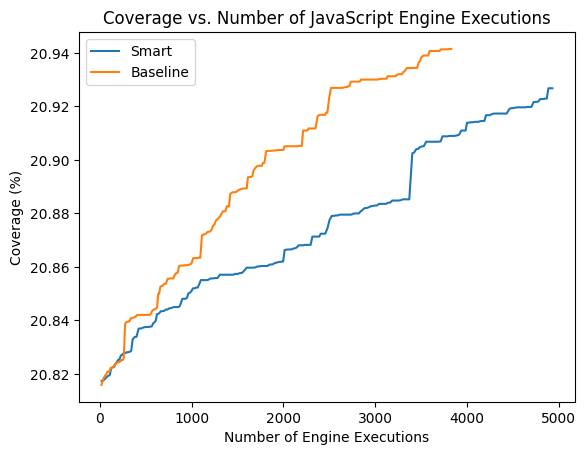

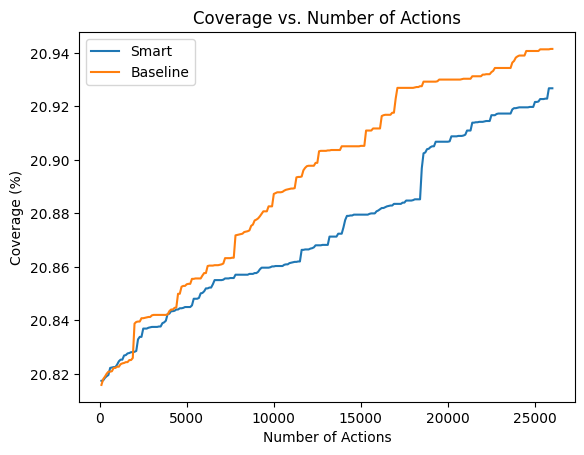

In [74]:
smart_x_exec = []
smart_x_action = []
smart_y = []

baseline_x_exec = []
baseline_x_action = []
baseline_y = []

for (execution, num_actions), coverage in smart_execution_coverage.items():
    smart_x_exec.append(execution)
    smart_x_action.append(num_actions)
    smart_y.append(coverage * 100)

for (execution, num_actions), coverage in baseline_execution_coverage.items():
    baseline_x_exec.append(execution)
    baseline_x_action.append(num_actions)
    baseline_y.append(coverage * 100)

plt.figure()
sns.lineplot(x=smart_x_exec, y=smart_y, label="Smart")
sns.lineplot(x=baseline_x_exec, y=baseline_y, label="Baseline")
plt.xlabel("Number of Engine Executions")
plt.ylabel("Coverage (%)")
plt.title("Coverage vs. Number of JavaScript Engine Executions")
plt.legend(loc="upper left")

plt.figure()
sns.lineplot(x=smart_x_action, y=smart_y, label="Smart")
sns.lineplot(x=baseline_x_action, y=baseline_y, label="Baseline")
plt.xlabel("Number of Actions")
plt.ylabel("Coverage (%)")
plt.title("Coverage vs. Number of Actions")

(-40.0, 10.0)

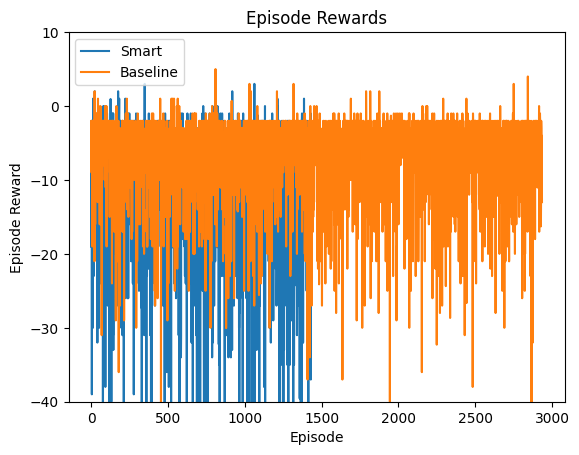

In [75]:
episodes = min(len(smart_episode_rewards), len(baseline_episode_rewards))

plt.figure()
sns.lineplot(
    x=np.arange(len(smart_episode_rewards_summed)),
    y=smart_episode_rewards_summed,
    label="Smart",
)
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.ylim(-40, 10)

plt.title("Episode Rewards")

sns.lineplot(
    x=np.arange(len(baseline_episode_rewards_summed)),
    y=baseline_episode_rewards_summed,
    label="Baseline",
)
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.ylim(-40, 10)

Text(0.5, 1.0, 'Loss')

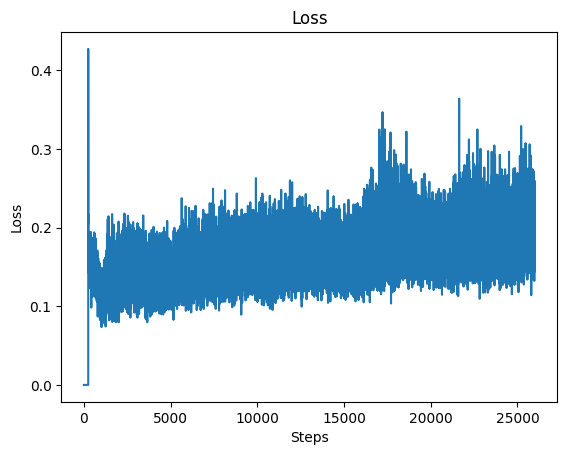

In [76]:
sns.lineplot(x=np.arange(len(smart_losses)), y=smart_losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss")

In [77]:
smart_episode_actions = [item for sublist in smart_episode_actions for item in sublist]
baseline_episode_actions = [
    item for sublist in baseline_episode_actions for item in sublist
]

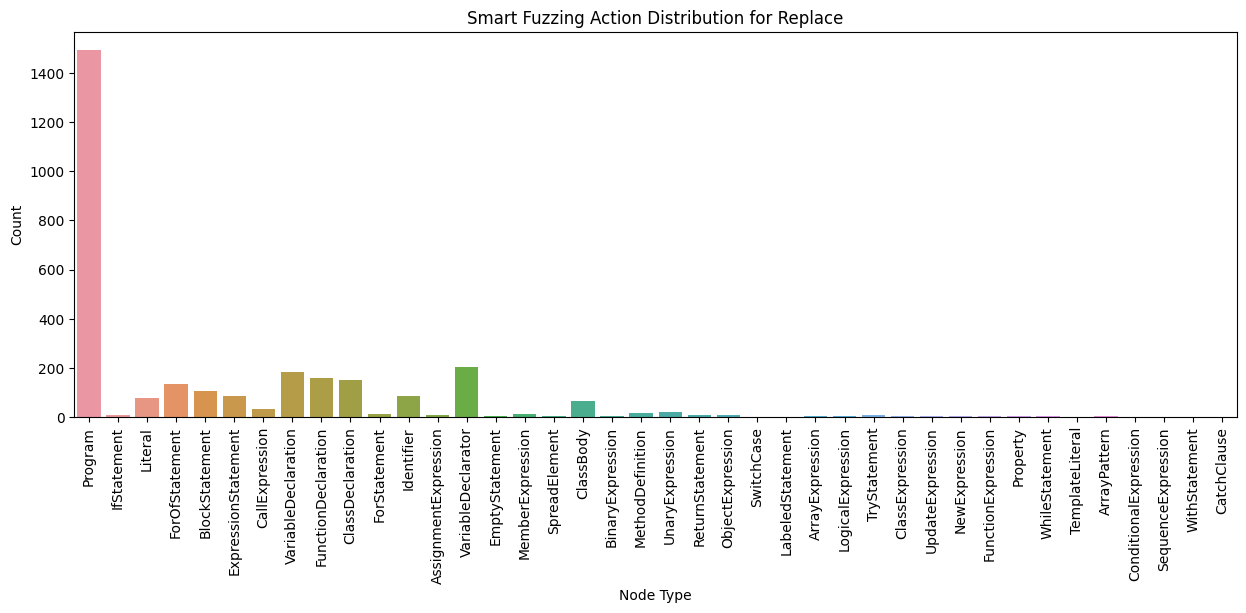

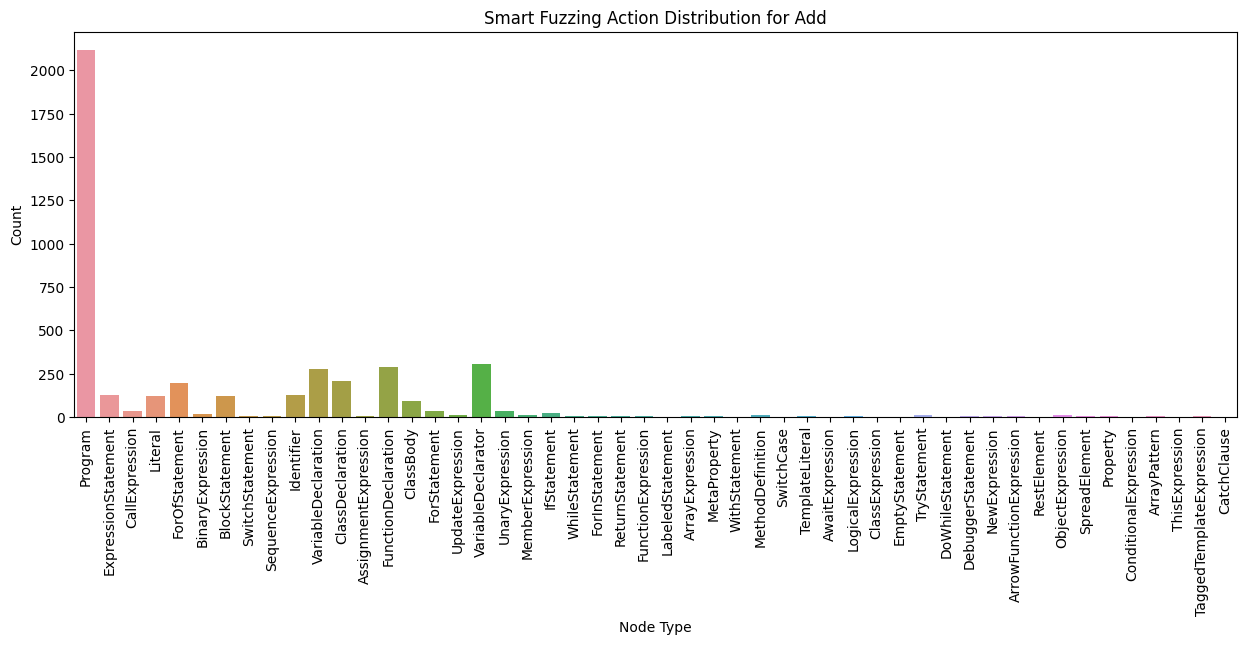

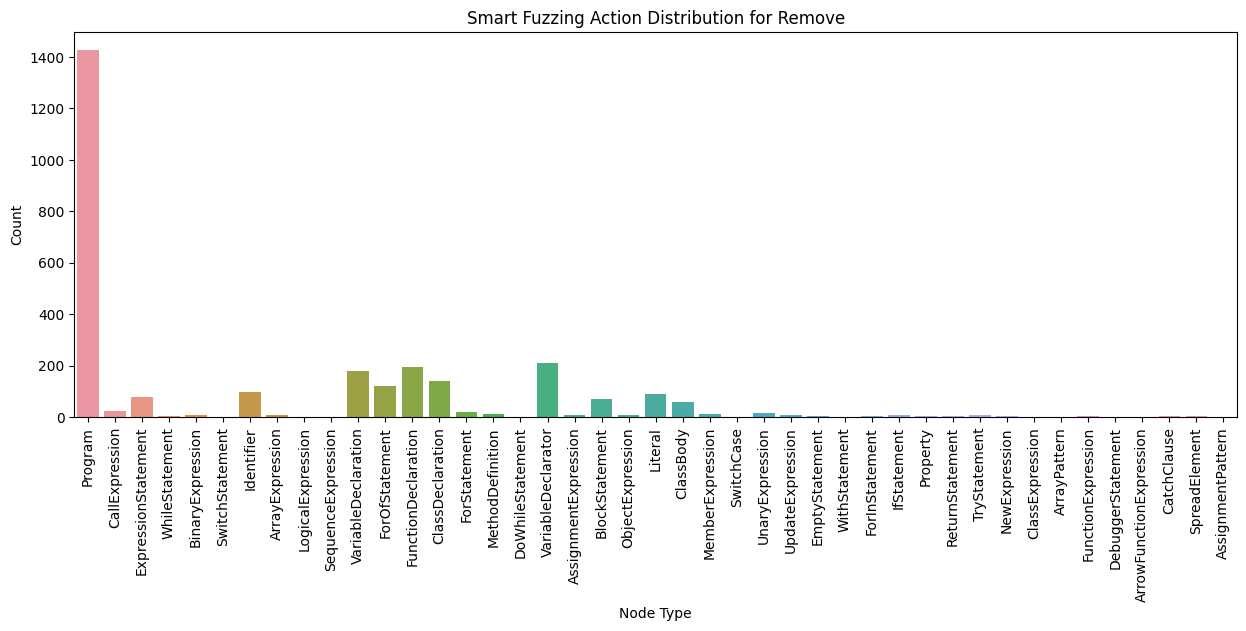

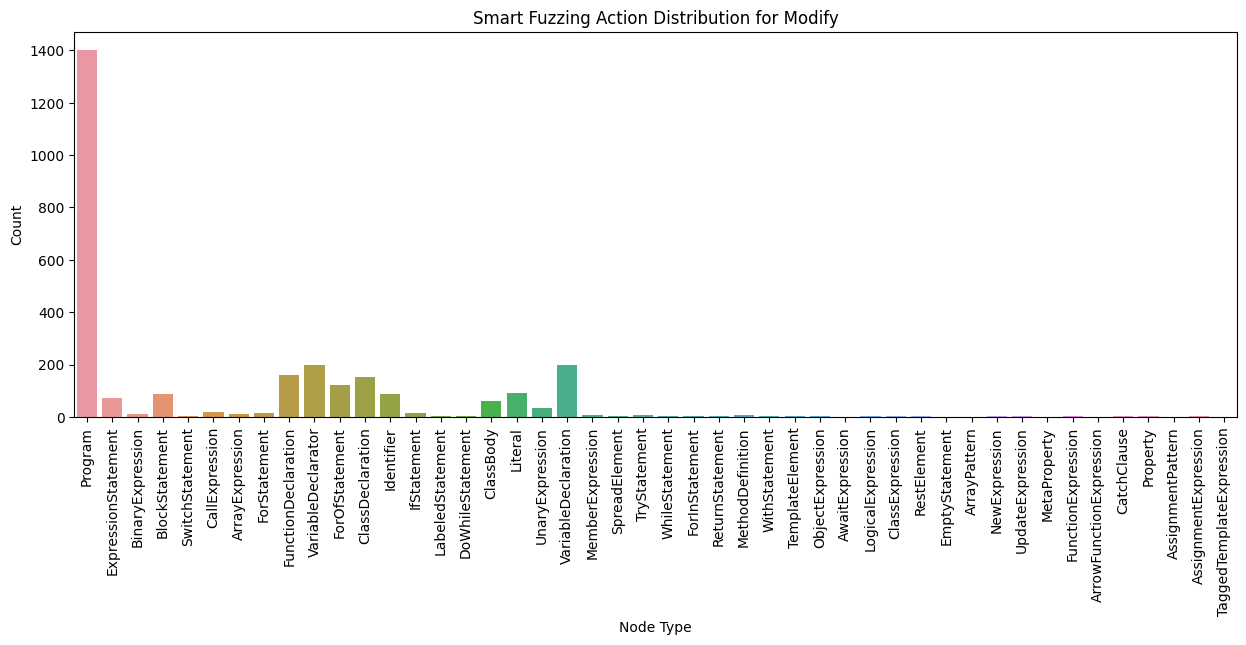

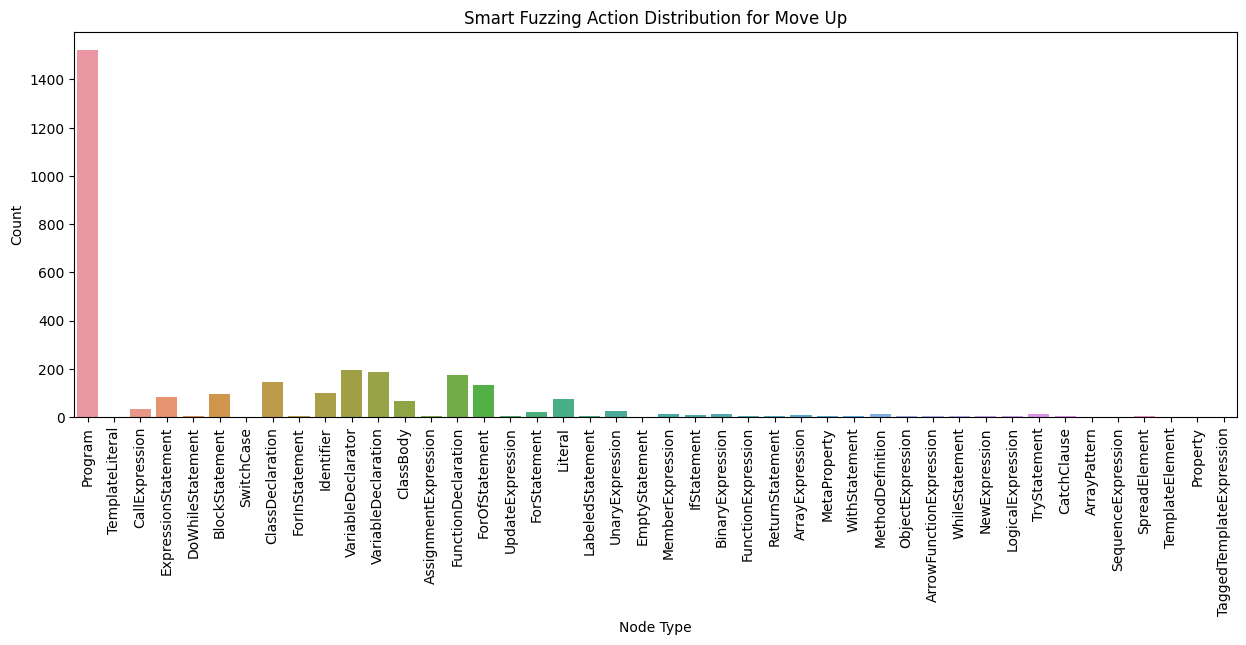

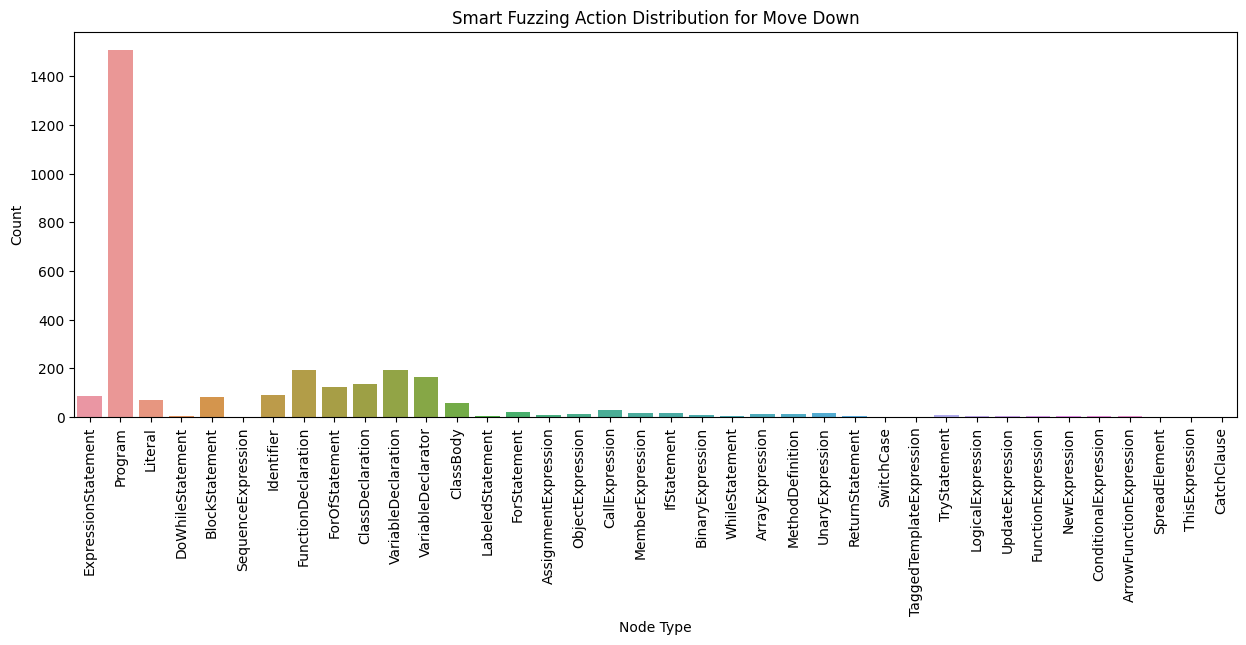

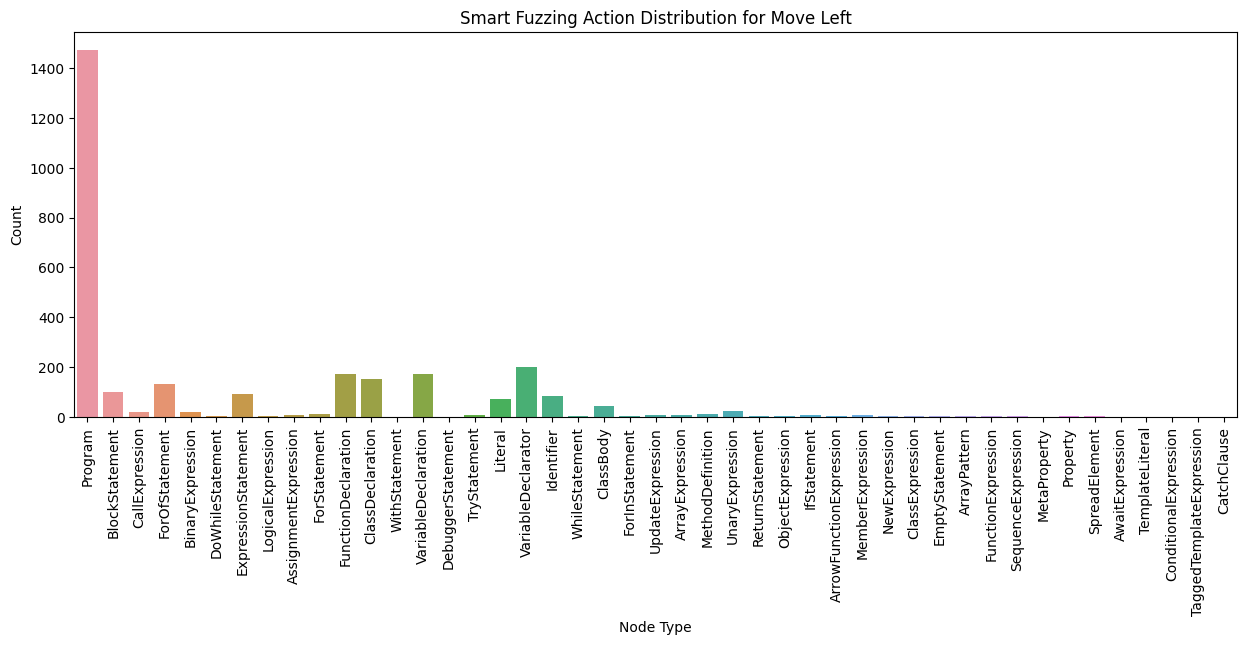

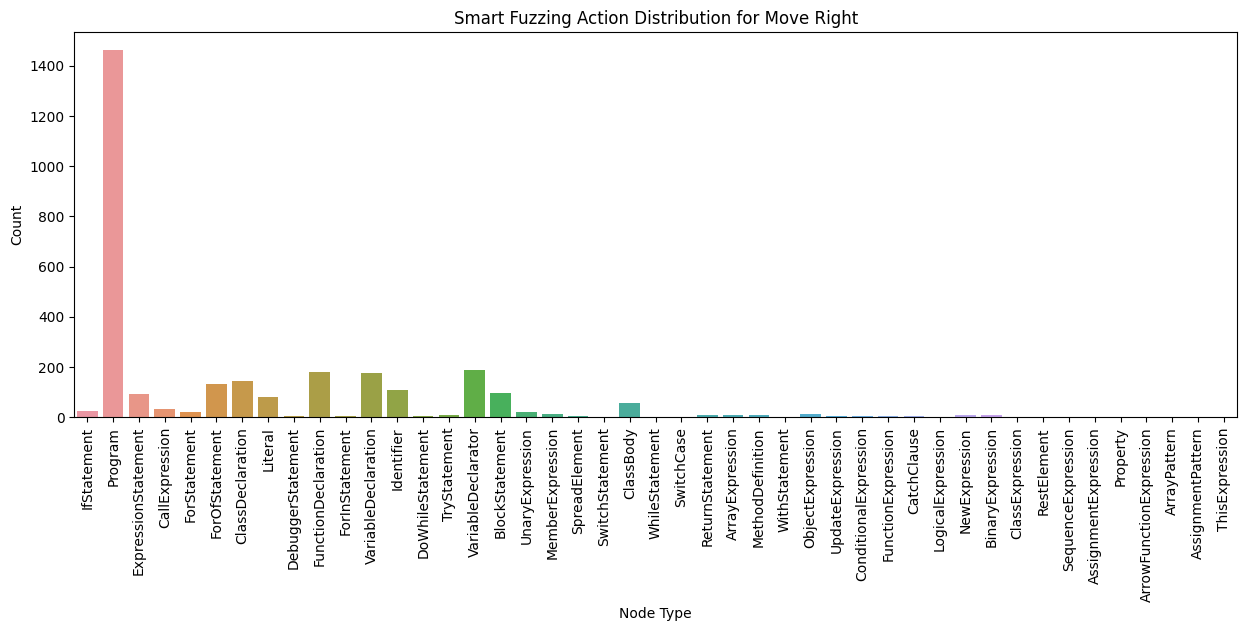

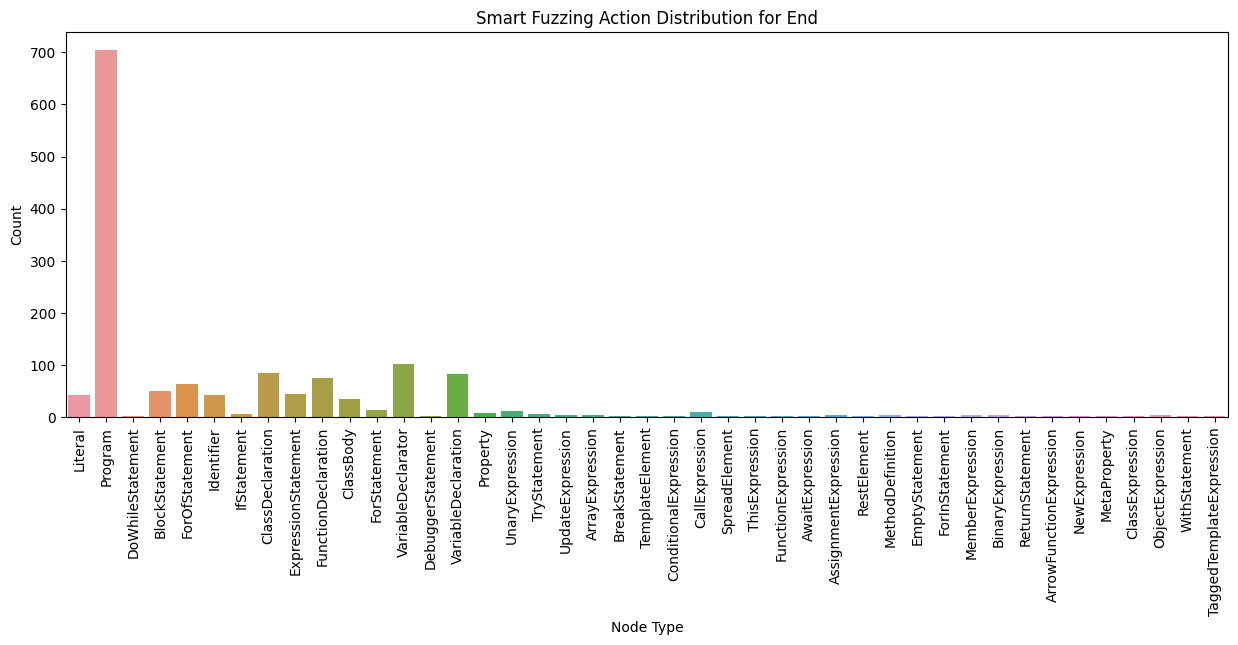

In [78]:
for action in FuzzingAction:
    smart_episode_actions_by_type = [
        x[1] for x in smart_episode_actions if x[0] == action
    ]
    baseline_episode_actions_by_type = [
        x[1] for x in baseline_episode_actions if x[0] == action
    ]

    smart_action_node_type_counts = Counter(smart_episode_actions_by_type)
    baseline_action_node_type_counts = Counter(baseline_episode_actions_by_type)

    smart_action_node_type_counts = pd.DataFrame(
        smart_action_node_type_counts.items(), columns=["node_type", "count"]
    )
    baseline_action_node_type_counts = pd.DataFrame(
        baseline_action_node_type_counts.items(), columns=["node_type", "count"]
    )

    # Plot the distribution of actions by node type using seaborn
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x="node_type", y="count", data=smart_action_node_type_counts)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set(xlabel="Node Type", ylabel="Count")
    plt.title(f"Smart Fuzzing Action Distribution for {action}")

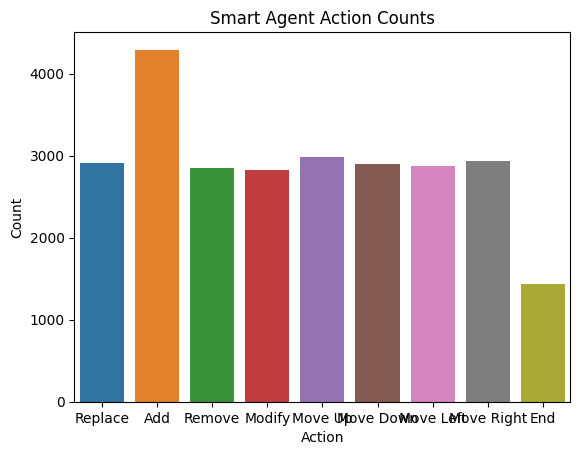

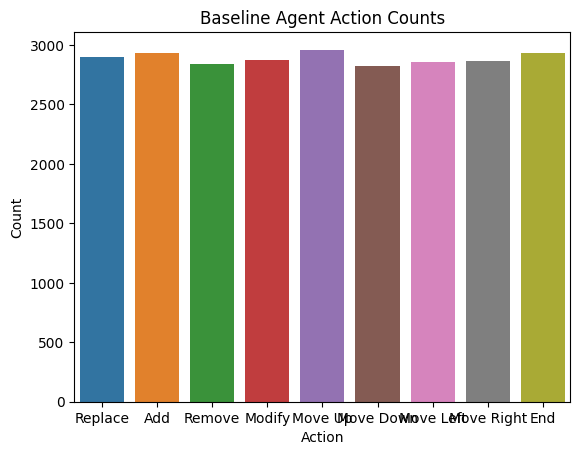

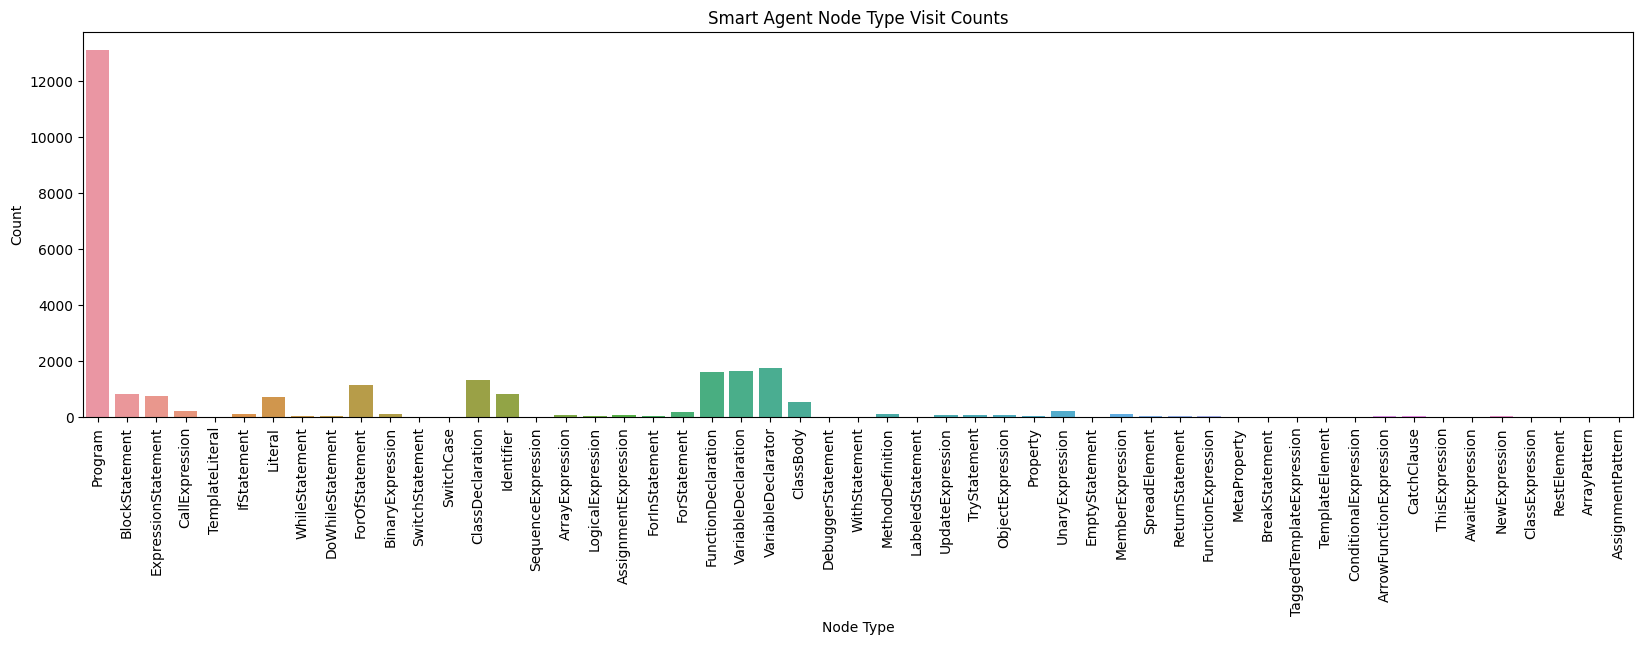

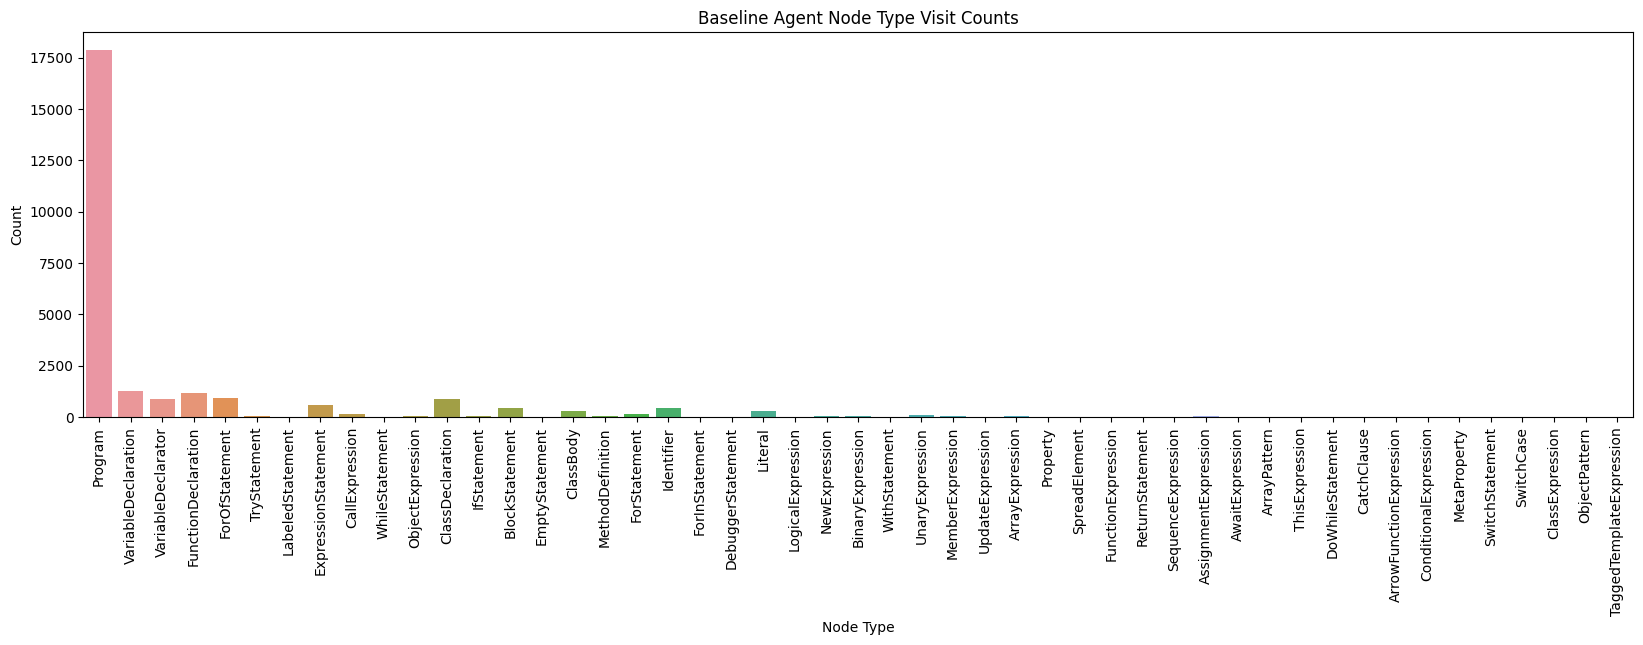

In [79]:
smart_actions, smart_node_types = zip(*smart_episode_actions)
baseline_actions, baseline_node_types = zip(*baseline_episode_actions)

smart_action_counts = Counter(smart_actions)
baseline_action_counts = Counter(baseline_actions)

smart_node_type_counts = Counter(smart_node_types)
baseline_node_type_counts = Counter(baseline_node_types)

smart_action_counts = pd.DataFrame.from_dict(
    smart_action_counts, orient="index"
).sort_index()
baseline_action_counts = pd.DataFrame.from_dict(
    baseline_action_counts, orient="index"
).sort_index()

smart_action_counts["name"] = [str(FuzzingAction(i)) for i in smart_action_counts.index]
baseline_action_counts["name"] = [
    str(FuzzingAction(i)) for i in baseline_action_counts.index
]

smart_node_type_counts = pd.DataFrame.from_dict(smart_node_type_counts, orient="index")
baseline_node_type_counts = pd.DataFrame.from_dict(
    baseline_node_type_counts, orient="index"
)

smart_node_type_counts["name"] = smart_node_type_counts.index
baseline_node_type_counts["name"] = baseline_node_type_counts.index

plt.figure()
ax = sns.barplot(x="name", y=0, data=smart_action_counts)
ax.set(xlabel="Action", ylabel="Count", title="Smart Agent Action Counts")
plt.legend([], [], frameon=False)

plt.figure()
ax = sns.barplot(x="name", y=0, data=baseline_action_counts)
ax.set(xlabel="Action", ylabel="Count", title="Baseline Agent Action Counts")
plt.legend([], [], frameon=False)

plt.figure(figsize=(20, 5))
ax = sns.barplot(x="name", y=0, data=smart_node_type_counts)
ax.set(xlabel="Node Type", ylabel="Count", title="Smart Agent Node Type Visit Counts")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend([], [], frameon=False)


plt.figure(figsize=(20, 5))
ax = sns.barplot(x="name", y=0, data=baseline_node_type_counts)
ax.set(
    xlabel="Node Type", ylabel="Count", title="Baseline Agent Node Type Visit Counts"
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend([], [], frameon=False)

In [80]:
import torch
``
t = torch.tensor([[1, 2, 3], [4, 5, 6]])
t.gather(1, torch.tensor([1, 2, 3]))

SyntaxError: invalid syntax (3985767097.py, line 2)